In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp plotting

# Plotting

> Time series visualizations

In [ ]:
#| hide
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Dict, List, Optional, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import numpy as np
import pandas as pd
from packaging.version import Version, parse as parse_version

from utilsforecast.compat import DataFrame, pl_Series
from utilsforecast.validation import validate_format

In [ ]:
#| exporti
def _filter_series(
    df, id_col, time_col, uids, models=None, max_insample_length=None
):
    out_cols = [id_col, time_col]
    if models is not None:
        out_cols.extend(models)
    out_cols = [col for pat in out_cols for col in df.columns if pat in col]
    if isinstance(df, pd.DataFrame):
        df = df.loc[df[id_col].isin(uids), out_cols].sort_values(time_col)
    else:
        import polars as pl

        df = df.filter(pl.col(id_col).is_in(uids)).select(*out_cols).sort(time_col)
    if max_insample_length is not None:
        df = df.groupby(id_col).tail(max_insample_length)
    return df

In [ ]:
#| export
def plot(
    df: DataFrame,
    forecasts_df: Optional[DataFrame] = None,
    unique_ids: Optional[List[str]] = None,
    plot_random: bool = True,
    max_ids: int = 8,
    models: Optional[List[str]] = None,
    level: Optional[List[float]] = None,
    max_insample_length: Optional[int] = None,
    plot_anomalies: bool = False,
    engine: str = 'matplotlib',
    palette: str = 'viridis',
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    target_col: str = 'y',
    seed: int = 0,
    resampler_kwargs: Optional[Dict] = None,
):
    """Plot forecasts and insample values.

    Parameters
    ----------
    df : pandas or polars DataFrame
        DataFrame with columns [`id_col`, `time_col`, `target_col`].
    forecasts_df : pandas or polars DataFrame, optional (default=None)
        DataFrame with columns [`id_col`, `time_col`] and models.
    unique_ids : list of str, optional (default=None)
        Time Series to plot.
        If None, time series are selected randomly.
    plot_random : bool (default=True)
        Select time series to plot randomly.
    max_ids : int (default=8)
        Maximum number of ids to plot.        
    models : list of str, optional (default=None)
        Models to plot.
    level : list of float, optional (default=None)
        Prediction intervals to plot.
    max_insample_length : int, optional (default=None)
        Maximum number of train/insample observations to be plotted.
    plot_anomalies : bool (default=False)
        Plot anomalies for each prediction interval.
    engine : str (default='matplotlib')
        Library used to plot. 'plotly', 'plotly-resampler' or 'matplotlib'.
    palette : str (default='viridis')
        Name of the matplotlib colormap to use.
    id_col : str (default='unique_id')
        Column that identifies each serie.
    time_col : str (default='ds')
        Column that identifies each timestep, its values can be timestamps or integers.
    target_col : str (default='y')
        Column that contains the target.
    seed : int (default=0)
        Seed used for the random number generator. Only used if plot_random is True.
    resampler_kwargs : dict
        Keyword arguments to be passed to plotly-resampler constructor.
        For further custumization ("show_dash") call the method,
        store the plotting object and add the extra arguments to
        its `show_dash` method.

    Returns
    -------
    fig : matplotlib or plotly figure
        Plot's figure
    """
    # checks
    supported_engines = ['matplotlib', 'plotly', 'plotly-resampler']
    if engine not in supported_engines:
        raise ValueError(f"engine must be one of {supported_engines}, got '{engine}'.")
    if plot_anomalies:
        if level is None:
            raise ValueError('In order to plot anomalies you have to specify the `level` argument')
        elif forecasts_df is None or not any('lo' in c for c in forecasts_df.columns):
            raise ValueError('In order to plot anomalies you have to provide a `forecasts_df` with prediction intervals.')
    if level is not None and not isinstance(level, list):
        raise ValueError(
            "Please use a list for the `level` argument "
            "If you only have one level, use `level=[your_level]`"
        )
    elif level is None:
        level = []
    validate_format(df, id_col, time_col, target_col)

    # models to plot
    if models is None:
        if forecasts_df is None:
            models = []
        else:
            exclude_strs = ['lo', 'hi', id_col, time_col, target_col]
            models = [
                col for col in forecasts_df.columns
                if all(s not in col for s in exclude_strs)
            ]

    # ids
    if unique_ids is None:
        uids: Union[np.ndarray, pl_Series, List] = df[id_col].unique()
    else:
        uids = unique_ids
    if len(uids) > max_ids and plot_random:
        rng = np.random.RandomState(seed)
        uids = rng.choice(uids, size=max_ids, replace=False)
    else:
        uids = uids[:max_ids]

    # filtering
    df = _filter_series(
        df=df,
        id_col=id_col,
        time_col=time_col,
        uids=uids,
        models=[target_col],
        max_insample_length=max_insample_length,
    )
    if forecasts_df is not None:
        forecasts_df = _filter_series(
            df=forecasts_df,
            id_col=id_col,
            time_col=time_col,
            uids=uids,
            models=[target_col] + models if target_col in forecasts_df else models,
            max_insample_length=None,
        )
        if isinstance(df, pd.DataFrame):
            df = pd.concat([df, forecasts_df])

        else:
            import polars as pl
            
            df = pl.concat([df, forecasts_df], how='align')

    # common setup
    n_series = len(uids)
    if n_series == 1:
        n_cols = 1            
    else:
        n_cols = 2
    quot, resid = divmod(n_series, n_cols)
    n_rows = quot + resid
    xlabel = f'Time [{time_col}]'
    ylabel = f'Target [{target_col}]'
    if parse_version(mpl.__version__) < Version('3.6'):
        cmap = plt.cm.get_cmap(palette, len(models) + 1)
    else:
        cmap = mpl.colormaps[palette].resampled(len(models) + 1)
    colors = [cm.to_hex(color) for color in cmap.colors]

    # define plot grid
    if engine.startswith('plotly'):
        try:
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots
        except ImportError:
            raise ImportError(
                "plotly is not installed. Please install it and try again.\n"
                "You can find detailed instructions at https://github.com/plotly/plotly.py#installation"
            )
        fig = make_subplots(
            rows=n_rows,
            cols=n_cols,
            vertical_spacing=0.15,
            horizontal_spacing=0.07,
            x_title=xlabel,
            y_title=ylabel,
            subplot_titles=[f'{id_col}={uid}' for uid in uids],
        )
        if engine == "plotly-resampler":
            try:
                from plotly_resampler import FigureResampler
            except ImportError:
                raise ImportError(
                    "plotly-resampler is not installed.\n"
                    "Please install it with `pip install plotly-resampler` or `conda install -c conda-forge plotly-resampler`"
                )
            resampler_kwargs = {} if resampler_kwargs is None else resampler_kwargs
            fig = FigureResampler(fig, **resampler_kwargs)
    else:
        fig, ax = plt.subplots(
            nrows=n_rows,
            ncols=n_cols,
            figsize=(24, 3.5 * n_rows),
            squeeze=False,
            gridspec_kw=dict(hspace=0.25, wspace=0.05),
        )

    def _add_mpl_plot(axi, df, y_col, levels):
        axi.plot(df[time_col], df[y_col], label=y_col, color=color)
        if y_col == target_col:
            return
        times = df[time_col]
        for level in levels:
            lo = df[f"{y_col}-lo-{level}"]
            hi = df[f"{y_col}-hi-{level}"]
            axi.fill_between(
                times,
                lo,
                hi,
                alpha=-float(level) / 100 + 1,
                color=color,
                label=f"{y_col}_level_{level}",
            )
            if plot_anomalies:                
                anomalies = df[target_col].lt(lo) | df[target_col].gt(hi)
                anomalies = anomalies.to_numpy().astype('bool')
                if not anomalies.any():
                    continue
                axi.scatter(
                    x=times.to_numpy()[anomalies],
                    y=df[target_col].to_numpy()[anomalies],
                    color=color,
                    s=30,
                    alpha=float(level) / 100,
                    label=f'{y_col}_anomalies_level_{level}',
                    linewidths=0.5,
                    edgecolors='red',
                )

    def _add_plotly_plot(fig, df, y_col, levels):
        show_legend = row == 0 and col == 0
        fig.add_trace(
            go.Scatter(
                x=df[time_col],
                y=df[y_col],
                mode='lines',
                name=y_col,
                legendgroup=y_col,
                line=dict(color=color, width=1),
                showlegend=show_legend,
            ),
            row=row+1,
            col=col+1,
        )
        if y_col == target_col:
            return
        x = np.concatenate([df[time_col], df[time_col][::-1]])        
        for level in levels:
            name = f'{y_col}_level_{level}'
            lo = df[f"{y_col}-lo-{level}"]
            hi = df[f"{y_col}-hi-{level}"]
            y = np.concatenate([hi, lo[::-1]])            
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=y,
                    fill='toself',
                    mode='lines',
                    fillcolor=color,
                    opacity=-float(level) / 100 + 1,
                    name=name,
                    legendgroup=name,
                    line=dict(color=color, width=1),
                    showlegend=show_legend,
                ),
                row=row+1,
                col=col+1,
            )
            if plot_anomalies:
                anomalies = df[target_col].lt(lo) | df[target_col].gt(hi)
                anomalies = anomalies.to_numpy().astype('bool')
                if not anomalies.any():
                    continue                
                name = f"{y_col}_anomalies_level_{level}"
                fig.add_trace(
                    go.Scatter(
                        x=df[time_col].to_numpy()[anomalies],
                        y=df[target_col].to_numpy()[anomalies],
                        fillcolor=color,
                        mode='markers',
                        opacity=float(level) / 100,
                        name=name,
                        legendgroup=name,
                        line=dict(color=color, width=0.7),
                        marker=dict(
                            size=4, line=dict(color='red', width=0.5)
                        ),
                        showlegend=show_legend,
                    ),
                    row=row+1,
                    col=col+1,
                )

    for i, uid in enumerate(uids):
        if isinstance(df, pd.DataFrame):
            uid_df = df[df[id_col].eq(uid)]
        else:
            cond = df[id_col].eq(uid)
            uid_df = df.filter(cond)
        row, col = divmod(i, n_cols)
        for y_col, color in zip([target_col] + models, colors):
            if engine == 'matplotlib':
                _add_mpl_plot(ax[row, col], uid_df, y_col, level)
            else:
                _add_plotly_plot(fig, uid_df, y_col, level)
        if engine == 'matplotlib':
            ax[row, col].set_title(f"{id_col}={uid}")
            ax[row, col].grid()
            if col == 0:
                ax[row, col].set_ylabel(ylabel)
            if row == n_rows - 1:
                ax[row, col].set_xlabel(xlabel)

    if engine == 'matplotlib':
        handles, labels = ax[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right')
        plt.close(fig)
        if len(ax.flat) > n_series:
            for axi in ax.flat[n_series:]:
                axi.set_axis_off()
    else:
        fig.update_xaxes(matches=None, showticklabels=True, visible=True)
        fig.update_layout(margin=dict(l=60, r=10, t=20, b=50))
        fig.update_layout(template="plotly_white", font=dict(size=10))
        fig.update_annotations(font_size=10)
        fig.update_layout(autosize=True, height=200 * n_rows)
    return fig

In [ ]:
show_doc(plot)

---

[source](https://github.com/Nixtla/utilsforecast/blob/main/utilsforecast/plotting.py#L36){target="_blank" style="float:right; font-size:smaller"}

### plot

>      plot
>            (df:Union[pandas.core.frame.DataFrame,polars.dataframe.frame.DataFr
>            ame], forecasts_df:Union[pandas.core.frame.DataFrame,polars.datafra
>            me.frame.DataFrame,NoneType]=None,
>            unique_ids:Optional[List[str]]=None, plot_random:bool=True,
>            max_ids:int=8, models:Optional[List[str]]=None,
>            level:Optional[List[float]]=None,
>            max_insample_length:Optional[int]=None, plot_anomalies:bool=False,
>            engine:str='matplotlib', palette:str='viridis',
>            id_col:str='unique_id', time_col:str='ds', target_col:str='y',
>            seed:int=0, resampler_kwargs:Optional[Dict]=None)

Plot forecasts and insample values.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Union |  | DataFrame with columns [`id_col`, `time_col`, `target_col`]. |
| forecasts_df | Union | None | DataFrame with columns [`id_col`, `time_col`] and models. |
| unique_ids | Optional | None | Time Series to plot.<br>If None, time series are selected randomly. |
| plot_random | bool | True | Select time series to plot randomly. |
| max_ids | int | 8 | Maximum number of ids to plot.         |
| models | Optional | None | Models to plot. |
| level | Optional | None | Prediction intervals to plot. |
| max_insample_length | Optional | None | Maximum number of train/insample observations to be plotted. |
| plot_anomalies | bool | False | Plot anomalies for each prediction interval. |
| engine | str | matplotlib | Library used to plot. 'plotly', 'plotly-resampler' or 'matplotlib'. |
| palette | str | viridis | Name of the matplotlib colormap to use. |
| id_col | str | unique_id | Column that identifies each serie. |
| time_col | str | ds | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str | y | Column that contains the target. |
| seed | int | 0 | Seed used for the random number generator. Only used if plot_random is True. |
| resampler_kwargs | Optional | None | Keyword arguments to be passed to plotly-resampler constructor.<br>For further custumization ("show_dash") call the method,<br>store the plotting object and add the extra arguments to<br>its `show_dash` method. |
| **Returns** | **matplotlib or plotly figure** |  | **Plot's figure** |

In [ ]:
from utilsforecast.data import generate_series

In [ ]:
series = generate_series(4, freq='D', equal_ends=True, with_trend=True)
rng = np.random.RandomState(0)
level = 80
test_pd = series.groupby('unique_id').tail(10).copy()
train_pd = series.drop(test_pd.index)
for i in range(2):
    test_pd[f'model{i}'] = test_pd['y'] * (1 + 0.01 * rng.rand(test_pd.shape[0]))
    level_offset = 0.1 * rng.rand(test_pd.shape[0]) * level / 100
    test_pd[f'model{i}-lo-{level}'] = test_pd[f'model{i}'] * (1 - level_offset)
    test_pd[f'model{i}-hi-{level}'] = test_pd[f'model{i}'] * (1 + level_offset)

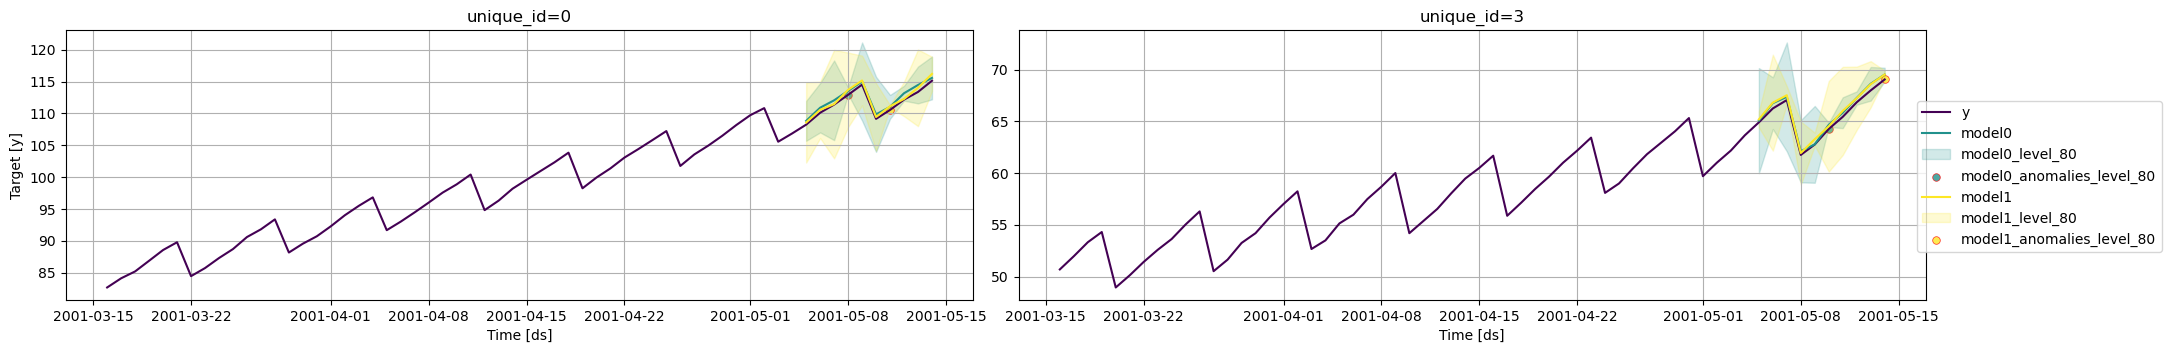

In [ ]:
plot(
    train_pd,
    forecasts_df=test_pd,
    unique_ids=[0, 3],
    plot_random=False,
    level=[level],    
    max_insample_length=50,
    engine='matplotlib',
    plot_anomalies=True,
)

In [ ]:
#| hide
from itertools import product

from fastcore.test import test_fail

from utilsforecast.compat import POLARS_INSTALLED, PLOTLY_INSTALLED, PLOTLY_RESAMPLER_INSTALLED

In [ ]:
#| hide
if POLARS_INSTALLED:
    import polars as pl

    train_pl = pl.DataFrame(train_pd.to_records(index=False))
    test_pl = pl.DataFrame(test_pd.to_records(index=False))

bools = [True, False]
polars = bools if POLARS_INSTALLED else [False]
anomalies = bools
randoms = bools
forecasts = bools
ids = [[0], [3, 1], None]
levels = [[80], None]
max_insample_lengths = [None, 50]
engines = ['matplotlib']
if PLOTLY_INSTALLED:
    engines.append('plotly')
if PLOTLY_RESAMPLER_INSTALLED:
    engines.append('plotly-resampler')
iterable = product(polars, ids, anomalies, levels, max_insample_lengths, engines, randoms, forecasts)

for as_polars, unique_ids, plot_anomalies, level, max_insample_length, engine, plot_random, with_forecasts in iterable:
    if POLARS_INSTALLED and as_polars:
        train = train_pl
        test = test_pl if with_forecasts else None
    else:
        train = train_pd
        test = test_pd if with_forecasts else None
    fn = lambda: plot(
        train,
        forecasts_df=test,
        unique_ids=unique_ids,
        plot_random=plot_random,
        plot_anomalies=plot_anomalies,
        level=level,    
        max_insample_length=max_insample_length,
        engine=engine,
    )
    if level is None and plot_anomalies:
        test_fail(fn, contains='specify the `level` argument')
    elif level is not None and plot_anomalies and not with_forecasts:
        test_fail(fn, contains='provide a `forecasts_df` with prediction')
    else:
        fn()